In [1]:
import os

import numpy as np
import pandas as pd
import random
import scipy

import io
from datetime import datetime
import functools

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from PIL import Image
import matplotlib.offsetbox as offsetbox
import matplotlib.patches as patches
import imageio



In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

2023-04-13 20:46:33.024417: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.12.0


In [3]:
def load_csv():
    df = pd.read_csv('data/plant_list.csv')
    df.drop(['Unnamed: 1', 'Unnamed: 15'], axis=1, inplace=True)
    df.columns = [c.lower() for c in df.columns]
    df = df.rename(columns={'spacing': 'diameter'})

    bool_cols = ['dry', 'medium', 'moist', 'sun', 'partial', 'shade', 'deer resistant']
    for col in bool_cols:
        b = pd.Series([False] * df.shape[0])
        b[df[col] == 'Y'] = True
        df[col] = b
    months = {
        mon: i + 3 for i, mon in enumerate(
            ['Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct']
            )
            }
    for k, v in months.items():
        df = df.replace(k, v)
    timecols = ['mintime', 'maxtime']
    for col in timecols: df[col] = pd.to_numeric(df[col])

    df['item'] = df['plant'].apply(lambda x: clean_str(x))
    df.set_index('item', inplace=True)
    return df

def clean_str(s):
    return s.replace("'", '').replace(' ', '_').lower()

In [12]:
PLANT_COLOURS_DICT = {
    'White': 'lightyellow',
    'Yellow': 'gold',
    'Pink': 'hotpink',
    'Blue': 'lightskyblue',
    'Lavender': 'plum',
    'Purple': 'darkviolet',
    'Green': 'lawngreen',
    'Red': 'crimson',
    'Orange': 'darkorange',
}
colours = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(colour)[:3])), name)
                for name, colour in colours.items())
COLOUR_NAMES = [name for hsv, name in by_hsv if (hsv[2] < 0.8) and (0.2 < hsv[2])]

def load_square_image(filename, size):
    img = Image.open(filename)
    img = img.resize((size, size))
    
    c = np.min(np.asarray(img).shape[:2])
    img = img.crop(((size - c) // 2, 0, c + (size - c) // 2, c))
    
    return img

def generate_circle(r, n_pts=100):
    theta = np.linspace(0, 2 * np.pi, n_pts).tolist()
    return [r * np.cos(th) for th in theta], [r * np.sin(th) for th in theta]

def generate_centred_circle(x, y, r):
    x_offset, y_offset = generate_circle(r)
    return [x + xi for xi in x_offset], [y + yi for yi in y_offset]

def plot_circle(x, y, r, ax):
    x_pts, y_pts = generate_centred_circle(x, y, r)
    ax.plot(x_pts, y_pts, 'k:', linewidth=1)
    ax.set(aspect='equal')

def plot_plan(items, xy, df_inventory, dims):
    f, ax = plt.subplots()
    for i, item in enumerate(items):
        plot_circle(xy[i, 0], xy[i, 1], df_inventory.loc[item]['diameter'] / 2, ax)
    ax.plot([0, dims[0], dims[0], 0, 0], [0, 0, dims[1], dims[1], 0], 'k--', linewidth=2)
    return f, ax

def plot_plant(plant, x, y, f, ax):
    df = load_csv()
    pts_per_screen_inch = 60
    screen_inches_per_image_foot = np.max(f.get_size_inches()) / np.max([ax.get_xlim()[1], ax.get_ylim()[1]])
    
    pts_per_image_foot = 12 * 2.54 * 5
    plant_footprint = df.loc[plant]['diameter']
    imagebox = offsetbox.OffsetImage(
        load_square_image(f'cleaned_pics/{plant}.png', int(plant_footprint * pts_per_image_foot)),
        zoom = pts_per_screen_inch * screen_inches_per_image_foot / pts_per_image_foot * 0.9
    ) 
    ax.add_artist(offsetbox.AnnotationBbox(
        imagebox, (x, y), frameon = False
    ))
    plot_circle(x, y, plant_footprint / 2, ax)
    
def plot_garden_sideview(items, xy, width, figsize_x):
    df = load_csv()

    height = df.loc[list(items)]['maxheight'].max()
    inds = np.argsort(xy[:, 1])[::-1]
    f, ax = plt.subplots(figsize=(figsize_x, figsize_x * height/width))
    ax.set(xlim=[0, width], ylim=[0, height], aspect='equal')
    plt.axis('off')
    f.tight_layout()
    for i in inds:
        plant_info = df.loc[items[i]]
        ax.add_patch(patches.Rectangle(
            (xy[i, 0] - plant_info['diameter'] / 2, 0), 
            plant_info['diameter'], np.mean([plant_info['maxheight'], plant_info['minheight']]),
            facecolor=PLANT_COLOURS_DICT[plant_info['colour']], edgecolor=[0.3] * 3, alpha=0.7,
            ))

def plot_garden_base(dims, figsize):
    width, height = dims
    f, ax = plt.subplots(1, 1, figsize=(figsize * width/height, figsize))
    ax.set(xlim=[0, width], ylim=[0, height], aspect='equal')
    plt.axis('off')
    f.tight_layout()
    return f, ax

def plot_plan(items, xy, df_inventory, dims):
    f, ax = plt.subplots()
    for i, item in enumerate(items):
        plot_circle(xy[i, 0], xy[i, 1], df_inventory.loc[item]['diameter'] / 2, ax)
    ax.plot([0, dims[0], dims[0], 0, 0], [0, 0, dims[1], dims[1], 0], 'k--', linewidth=2)
    return f, ax

def scatter_heights(items, xy, df_inventory, dims, ax=None, figsize=4):
    if not ax:
        f, ax = plot_garden_base(dims, figsize)
    # pts are 1/72 inch, i.e. 72pt/plot".  given fs plot"/1 plot, 1 plot/dims[1] real feet, 
    # i.e. 72*fs/dims[1] pts/real foot
    cm = ax.scatter(
        xy[:,0], xy[:, 1], 
        s = (
            (72 * figsize / dims[1]) ** 2
            * np.pi * (df_inventory.loc[list(items)]['diameter'].values / 2) ** 2
        ),
        c = df_inventory.loc[list(items)]['maxheight'].values,
        cmap=sns.color_palette('flare', as_cmap=True))
    return cm, ax

def plot_garden(items, xy, df_inventory, dims, figsize=10, plot_sideview=True):
    f, ax = plot_garden_base(dims, figsize)
    for i, item in enumerate(items):
        plot_plant(item, xy[i, 0], xy[i, 1], f, ax)
    if plot_sideview:
        plot_garden_sideview(items, xy, width=dims[0], figsize_x=f.get_size_inches()[1])
        f, ax = plot_garden_base(dims, 3)

In [5]:
def pick_random_spot(dims, buffer):
    scale = 1
    return (random.random() * (dims[0] - buffer), random.random() * (dims[1] - buffer))

def space_remaining(items, df_inventory, dims):
    return (dims[0] * dims[1] 
            - df_inventory.loc[list(items)]['diameter'].apply(lambda x: np.pi * (x/2)**2).sum())

def break_apart_inventory(items, df_inventory):
    radii = df_inventory.loc[list(items)]['diameter'].values.astype('float32') / 2
    combi_radii = radii.reshape((len(items), 1)) + radii.reshape((1, len(items)))
    heights = df_inventory.loc[list(items)]['maxheight'].values.astype('float32') 
    return radii, combi_radii, heights

def create_initial_plan(n_types, df_inventory, dims):
    
    choices = df_inventory[df_inventory['diameter'] < min(dims) / 4].sample(n_types)
    items, x, y = [], [], []
    # optimal packing density of uniform circles is ~90%
    buffer = 10 * 2
    while True:
        items += [choices.sample(1).index[0]]
        nx, ny = pick_random_spot(dims, df_inventory.loc[items[-1]]['diameter'] / 2)
        x += [nx]
        y += [ny]

        if (space_remaining(items, df_inventory, dims)
            < buffer * (np.pi * (choices.loc[list(items)]['diameter'].min() / 2) ** 2)): break
    print(f'{space_remaining(items, df_inventory, dims) / np.prod(dims):.0%} unused')
    return tuple(items), np.vstack((np.array(x), np.array(y))).transpose()



In [6]:
def pairwise_dist_tf(A, B):  
  """
  Computes pairwise distances between each elements of A and each elements of B.
  Args:
    A,    [m,d] matrix
    B,    [n,d] matrix
  Returns:
    D,    [m,n] matrix of pairwise distances
  """
  # squared norms of each row in A and B
  na = tf.reduce_sum(tf.square(A), 1)
  nb = tf.reduce_sum(tf.square(B), 1)
  
  # na as a row and nb as a co"lumn vectors
  na = tf.reshape(na, [-1, 1])
  nb = tf.reshape(nb, [1, -1])

  return tf.sqrt(tf.maximum(na - 2*tf.matmul(A, B, False, True) + nb, 0.0))

In [29]:
def run_gradient_descent(items, df_inventory, dims, xy):
    def suboptimalness_wrapper(weights):
        # Factors going into optimisation
        def calculate_suboptimalness():
            return sum([k() * v for k, v in weights.items()])
        return calculate_suboptimalness
    def record_step(i, score):
        print(f'Step {i:>6}: {score.numpy():>16,.2f}')
        f, ax = plot_garden_base(dims, 6)
        scatter_heights(items, tf_xy.numpy(), df_inventory, dims, ax)
        ax.text(dims[0]/2, dims[1]/2, f'Step {i:>6}: {score.numpy():>16,.2f}', ha='center', va='center')
        plt.savefig(f'{logdir}/step{i}.png')
        plt.close()
    def run_optimise_loop(weights, n_steps, epsilon):
        opt = tf.keras.optimizers.Adam(learning_rate=epsilon)
        score = suboptimalness_wrapper(weights)()
        comp_score = score
        for i in range(n_steps):
            opt.minimize(
                suboptimalness_wrapper(weights), [tf_xy]
                )
            old_score = score
            score = suboptimalness_wrapper(weights)()
            if (score / comp_score < 0.75) or (1e3 < n_steps and i % (n_steps // 1e3) == 0): 
                record_step(i, score)
                comp_score = score
            if abs(score - old_score) < epsilon:
                break
        return tf_xy
    
    # Optimisation things
    def out_of_bounds():
                below_zero = tf.reduce_sum(tf.nn.relu([[r] for r in radii] - tf_xy))
                above_max = tf.reduce_sum(tf.nn.relu(tf_xy - (np.array(dims) - [[r] for r in radii])))
                return (below_zero + above_max)
    def circles_dont_overlap():
        cr = combi_radii
        np.fill_diagonal(cr, 0)
        # want the sum of the two radii <= pairwise distance
        # and use relu to set all negative numbers (i.e. dist > radii) to zero
        return tf.reduce_sum(
            tf.reduce_sum(tf.nn.relu(cr - pairwise_dist_tf(tf_xy, tf_xy)), 1)
        ) ** 2
    def height_increases_with_y():
        min_h = min(heights)
        max_h = max(heights)
        # working towards having max_h at dims[1] and min_h at 0Y
        # Between 0 and dims[1] ft in Y, want to increase from Z from
        # ~ av. min_h to ~ av. max_h
        # i.e. want height = min_h + y / dims[1] * (max_h - min_h)
        return tf.reduce_sum(abs(
            tf_xy[:, 1] * (max_h - min_h) / (dims[1] - max(radii)) + min_h - heights
        ))

    # Set up directory for images
    logdir = "logs/plots/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    os.mkdir(logdir)

    radii, combi_radii, heights = break_apart_inventory(items, df_inventory)
    tf_xy = tf.Variable(xy, dtype='float32')
    
    # Stage One - 
    tf_xy = run_optimise_loop(
        n_steps=100, epsilon=0.1, 
        weights={out_of_bounds: 1, height_increases_with_y: 10, circles_dont_overlap:1e-5}
    )
    # # Stage Two
    # tf_xy = run_optimise_loop(
    #     n_steps = int(1e5), epsilon = 1e-3, weights={out_of_bounds: 1, circles_dont_overlap: 1}
    # )
    
    images =  [os.path.join(logdir, f) for f in os.listdir(logdir)]
    images.sort(key=lambda x: os.path.getmtime(x))
    ims = [imageio.v2.imread(images)]
    imageio.mimwrite(f'{logdir}', ims)
        
    return tf_xy.numpy()



In [26]:
logdir = './logs/plots/20230413-205221/'
images =  [os.path.join(logdir, f) for f in os.listdir(logdir)]
    images.sort(key=lambda x: os.path.getmtime(x))
    ims = [imageio.v2.imread(images)]
    imageio.mimwrite(f'{logdir}', ims)
f

['./logs/plots/20230413-205221/step6.png',
 './logs/plots/20230413-205221/step13.png',
 './logs/plots/20230413-205221/step18.png',
 './logs/plots/20230413-205221/step22.png',
 './logs/plots/20230413-205221/step25.png',
 './logs/plots/20230413-205221/step28.png',
 './logs/plots/20230413-205221/step30.png',
 './logs/plots/20230413-205221/step40.png',
 './logs/plots/20230413-205221/step42.png',
 './logs/plots/20230413-205221/step51.png']

In [28]:
df_inventory = load_csv()
dims = (5, 5);
items, xy = create_initial_plan(10, df_inventory, dims)
xy_new = run_gradient_descent(items, df_inventory, dims, xy)


35% unused
Step      4:           156.84
Step      8:           115.76
Step     12:            82.37
Step     17:            58.01
Step     21:            43.35
Step     24:            30.84
Step     27:            20.88
Step     36:            13.98
Step     39:            10.41


/var/folders/s6/b39_j6mj1cb8945kp6yy6m500000gp/T/ipykernel_29858/2918114148.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ims = [imageio.imread(images)]


OSError: Cannot understand given URI: ['logs/plots/20230413-210300/step4.png', 'logs/plots/2023....

In [167]:
import functools

In [182]:
def scatter_heights(xy, items, df_inventory, dims, ax=None, figsize=4):
    print(items)
    if not ax:
        f, ax = plot_garden_base(dims, figsize)
    # pts are 1/72 inch, i.e. 72pt/plot".  given fs plot"/1 plot, 1 plot/dims[1] real feet, 
    # i.e. 72*fs/dims[1] pts/real foot
    cm = ax.scatter(
        xy[:,0], xy[:, 1], 
        s = (
            (72 * figsize / dims[1]) ** 2
            * np.pi * (df_inventory.loc[list(items)]['diameter'].values / 2) ** 2
        ),
        c = df_inventory.loc[list(items)]['maxheight'].values,
        cmap=sns.color_palette('flare', as_cmap=True))
    return cm, ax

Error in callback <function _draw_all_if_interactive at 0x12491f420> (for post_execute):


TypeError: scatter_heights() got multiple values for argument 'xy'

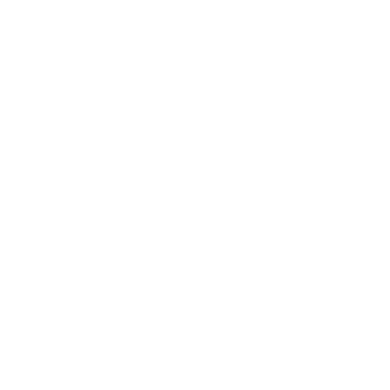

In [186]:
ani = plot_animation(history, items, df_inventory)

In [185]:
def plot_animation(history, items, df_inventory):
    f, ax = plot_garden_base(dims, 4)
    i, s, xys = zip(*history)
    return animation.FuncAnimation(
        f, functools.partial(
            scatter_heights, xy=[], items=items, df_inventory=df_inventory, dims=dims, ax=ax
            ),
        frames=list(xys),
        blit=False)
    
    



In [6]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

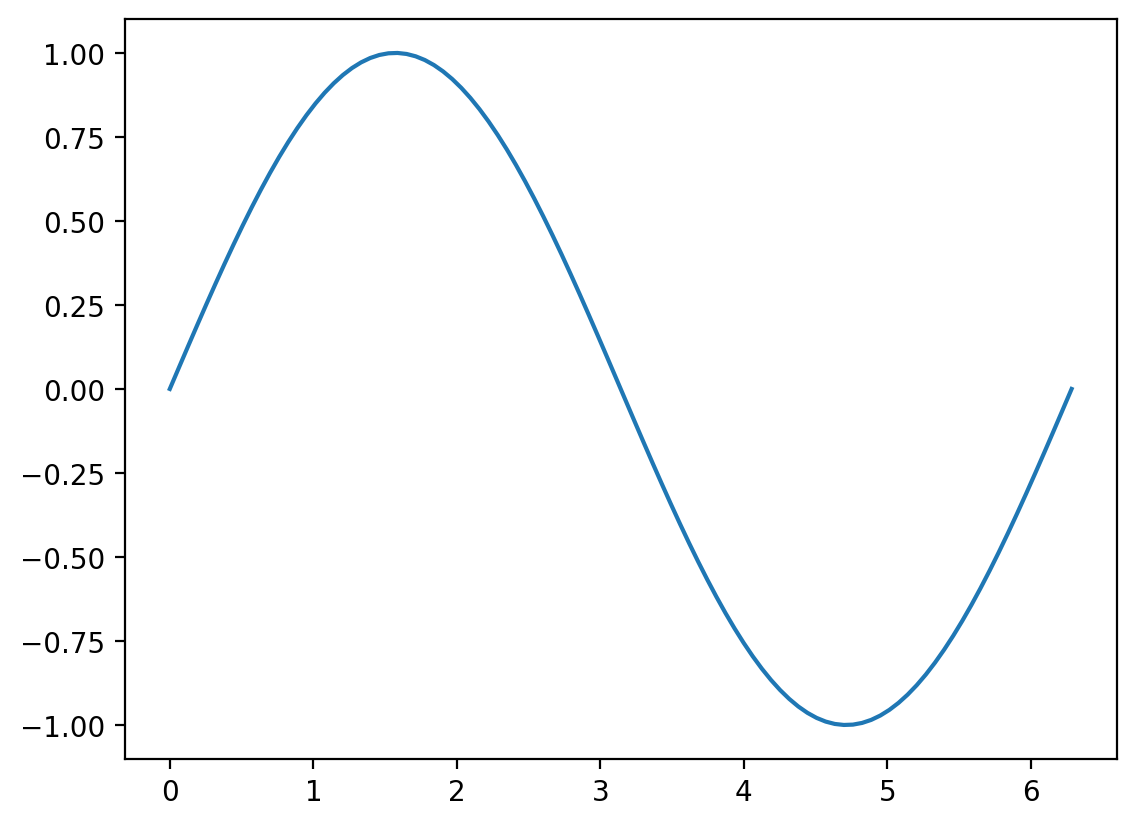

In [2]:
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

plt.plot(x, y)
plt.show()

In [3]:
# Enable interactive plot
%matplotlib notebook
%matplotlib notebook

In [9]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display

RuntimeError: Requested MovieWriter (ffmpeg) not available

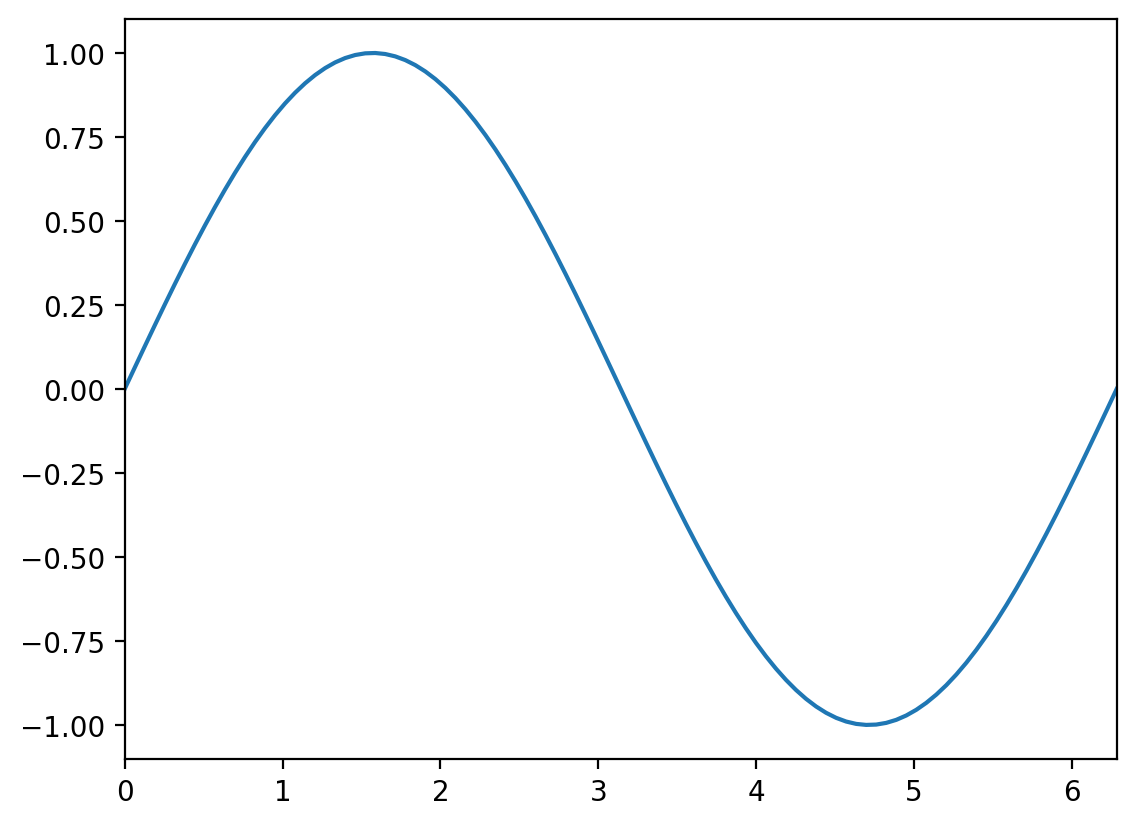

In [10]:
fig, ax = plt.subplots()

line, = ax.plot([])

ax.set_xlim(0, 2*np.pi)
ax.set_ylim(-1.1, 1.1)

def animate(frame_num):
    y = np.sin(x + 2*np.pi * frame_num/100)
    line.set_data((x, y))
    return line

anim = FuncAnimation(fig, animate, frames=100, interval=5)
video = anim.to_html5_video()
html = display.HTML(video)

(<matplotlib.collections.PathCollection at 0x1bc8f5fd0>, <Axes: >)

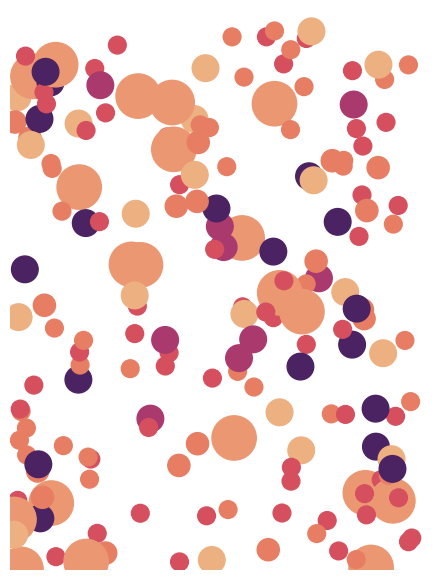

In [85]:
f, ax = plot_garden_base(dims, 6)
scatter_heights(items, xy, df_inventory, dims, ax=ax)
# plot_garden(items, xy_new, df_inventory, dims)